# Notebook resumen
Para este proyecto de Machine Learning, hemos elegido un set de datos de Kaggle que contiene un ranking de los 100 repositorios de Python mas populares desde diciembre de 2018 hasta el inicio del trabajo en febrero de 2024. El objetivo es crear un modelo que prediga el número de forks que se realizan sobre un repostorio.

## Librerias

In [2]:
# Manejo de datos
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualización
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from matplotlib.ticker import FixedLocator, FixedFormatter

import seaborn as sns

# Preporcesado
from sklearn.preprocessing import LabelEncoder, RobustScaler

# Clusterinzación
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

# Baselines y optimización
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Modelos
from sklearn.linear_model import ElasticNet, Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor

# Metricas
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# nlp
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Warnigs
import warnings
warnings.filterwarnings("ignore")

## Carga de datos

In [3]:
df = pd.read_csv("..\data\\raw\popular_python_projects.csv")

## Índice

1. EDA

2. Limpieza

3. Feature engeneering

4. Transformaciones y escalado

5. Clusterización

6. Modelo cluster 0

7. Modelo cluster 1

8. Modelo cluster 2
 
9. Modelo cluster 3

10. Modelo cluster 0

## 1. EDA

### Primera exploración

In [4]:
df.head()

,date,rank,item,repo_name,stars,forks,language,repo_url,username,issues,last_commit,description
0,2018-12-18,1,Python,awesome-python,58777,11448,Python,https://github.com/vinta/awesome-python,vinta,439,2018-12-13T08:29:32Z,"A curated list of awesome Python frameworks, l..."
1,2018-12-18,2,Python,system-design-primer,53575,7570,Python,https://github.com/donnemartin/system-design-p...,donnemartin,68,2018-12-18T11:20:56Z,Learn how to design large-scale systems. Prep ...
2,2018-12-18,3,Python,models,46039,28053,Python,https://github.com/tensorflow/models,tensorflow,1324,2018-12-18T02:29:33Z,Models and examples built with TensorFlow
3,2018-12-18,4,Python,public-apis,45373,4707,Python,https://github.com/toddmotto/public-apis,toddmotto,5,2018-12-18T11:24:53Z,A collective list of free APIs for use in soft...
4,2018-12-18,5,Python,youtube-dl,44956,7820,Python,https://github.com/rg3/youtube-dl,rg3,2566,2018-12-18T11:18:21Z,Command-line program to download videos from Y...


In [5]:
df.tail()

,date,rank,item,repo_name,stars,forks,language,repo_url,username,issues,last_commit,description
170275,2024-02-03,96,Python,diffusers,20767,4297,Python,https://github.com/huggingface/diffusers,huggingface,289,2024-02-03T02:59:18Z,🤗 Diffusers: State-of-the-art diffusion models...
170276,2024-02-03,97,Python,Awesome-Linux-Software,20672,2005,Python,https://github.com/luong-komorebi/Awesome-Linu...,luong-komorebi,8,2024-01-27T10:02:38Z,🐧 A list of awesome Linux softwares
170277,2024-02-03,98,Python,insightface,20230,5040,Python,https://github.com/deepinsight/insightface,deepinsight,1011,2023-12-24T05:29:03Z,State-of-the-art 2D and 3D Face Analysis Project
170278,2024-02-03,99,Python,Gooey,20130,1091,Python,https://github.com/chriskiehl/Gooey,chriskiehl,126,2024-01-29T12:27:25Z,Turn (almost) any Python command line program ...
170279,2024-02-03,100,Python,DeepFaceLive,20093,3172,Python,https://github.com/iperov/DeepFaceLive,iperov,1,2023-07-28T10:14:16Z,Real-time face swap for PC streaming or video ...


In [6]:
df.shape

(170280, 12)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170280 entries, 0 to 170279
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   date         170280 non-null  object
 1   rank         170280 non-null  int64 
 2   item         170280 non-null  object
 3   repo_name    170280 non-null  object
 4   stars        170280 non-null  int64 
 5   forks        170280 non-null  int64 
 6   language     170280 non-null  object
 7   repo_url     170280 non-null  object
 8   username     170280 non-null  object
 9   issues       170280 non-null  int64 
 10  last_commit  170280 non-null  object
 11  description  168687 non-null  object
dtypes: int64(4), object(8)
memory usage: 15.6+ MB


Si el ranking es el top 100, eso quiere decir que siempre que se actualiza la base de datos se añade una entrada por puesto.

In [8]:
df["rank"].value_counts()

rank
1      1722
32     1722
34     1722
35     1722
36     1722
       ... 
75     1674
76     1674
77     1674
78     1674
100    1674
Name: count, Length: 100, dtype: int64

In [9]:
#comprobamos que el ranking tiene distintos repositorios
df[df["rank"] == 1] 

,date,rank,item,repo_name,stars,forks,language,repo_url,username,issues,last_commit,description
0,2018-12-18,1,Python,awesome-python,58777,11448,Python,https://github.com/vinta/awesome-python,vinta,439,2018-12-13T08:29:32Z,"A curated list of awesome Python frameworks, l..."
100,2018-12-19,1,Python,awesome-python,58801,11454,Python,https://github.com/vinta/awesome-python,vinta,439,2018-12-13T08:29:32Z,"A curated list of awesome Python frameworks, l..."
200,2018-12-20,1,Python,awesome-python,58840,11455,Python,https://github.com/vinta/awesome-python,vinta,439,2018-12-20T06:49:58Z,"A curated list of awesome Python frameworks, l..."
300,2018-12-21,1,Python,awesome-python,58882,11465,Python,https://github.com/vinta/awesome-python,vinta,440,2018-12-20T12:52:04Z,"A curated list of awesome Python frameworks, l..."
400,2018-12-22,1,Python,awesome-python,58936,11470,Python,https://github.com/vinta/awesome-python,vinta,439,2018-12-20T12:52:04Z,"A curated list of awesome Python frameworks, l..."
...,...,...,...,...,...,...,...,...,...,...,...,...
169780,2024-01-30,1,Python,public-apis,277535,31168,Python,https://github.com/public-apis/public-apis,public-apis,4,2024-01-28T01:47:43Z,A collective list of free APIs
169880,2024-01-31,1,Python,public-apis,277656,31177,Python,https://github.com/public-apis/public-apis,public-apis,2,2024-01-28T01:47:43Z,A collective list of free APIs
169980,2024-02-01,1,Python,public-apis,277800,31191,Python,https://github.com/public-apis/public-apis,public-apis,2,2024-01-31T06:04:35Z,A collective list of free APIs
170080,2024-02-02,1,Python,public-apis,277965,31207,Python,https://github.com/public-apis/public-apis,public-apis,2,2024-02-01T09:06:25Z,A collective list of free APIs


In [10]:
df["language"].value_counts()

language
Python    170280
Name: count, dtype: int64

In [11]:
df["item"].value_counts()

item
Python    170280
Name: count, dtype: int64

In [12]:
# cantindad de nulos
df.isna().sum()/len(df)

date           0.000000
rank           0.000000
item           0.000000
repo_name      0.000000
stars          0.000000
forks          0.000000
language       0.000000
repo_url       0.000000
username       0.000000
issues         0.000000
last_commit    0.000000
description    0.009355
dtype: float64

In [13]:
# un repositorio se puede repetir?
df["repo_name"].value_counts()

repo_name
Python                         2343
algo                           1799
big-list-of-naughty-strings    1247
glances                        1246
ansible                        1242
                               ... 
paraphraser                       1
keras-squeezenet                  1
One-Shot-Object-Detection         1
face.evoLVe                       1
sae-python-dev-guide              1
Name: count, Length: 4247, dtype: int64

In [14]:
df.describe()

,rank,stars,forks,issues
count,170280.000000,170280.000000,170280.000000,170280.000000
mean,50.161734,24222.825476,5317.970302,428.204205
std,28.825082,22172.348577,6466.364554,953.338588
min,1.000000,207.000000,0.000000,0.000000
25%,25.000000,13090.000000,1658.000000,32.000000
50%,50.000000,18139.000000,3260.000000,136.000000
75%,75.000000,28049.250000,6252.000000,381.000000
max,100.000000,278085.000000,51066.000000,16431.000000


Tras una primera exploración estas son las principales características del set de datos:
- Cada semana se actualiza el ranking de ranking 100 de los repositiorios.
- Existen repositorios con distintas entradas, pues si cuando se actualizó el set de datos se mantenía en el top 100 se añade también, pero se actualiza su ranking, forks e issues.
- Las variables item y lenguaje no aportan información porque ambas indican que el el repositorio es en lenguaje python.
- El dataframe apenas tiene valores nulos (solo hay en la variable *description* y no llega al 1%) y no tiene duplicados.

### Cardinalidad

In [15]:
def cardinalidad(df):

    columnas = df.columns

    unicos = df.nunique()

    card_100 = [(df[i].nunique()/len(df))*100 for i in df]

    tipo_dato = []
    
    for x in df.columns:
        if df[x].dtypes == '<M8[ns]':
            y = "datetime"
            tipo_dato.append(y)
        elif df[x].nunique() == 2:
            y = "boolean"
            tipo_dato.append(y)
        elif df[x].nunique() != 2 and df[x].dtype == "O":
            y = "categorical"
            tipo_dato.append(y)
        elif df[x].nunique() != 2 and df[x].dtype == "float64":
            y = "numerical"
            tipo_dato.append(y)
        elif df[x].nunique() != 2 and df[x].dtype == "int64":
            y = "numerical"
            tipo_dato.append(y)

    cardinality = pd.DataFrame({"Columna":columnas, "Total de únicos":unicos, 
                                "Cardinalidad (%)":card_100, "Tipo de dato": tipo_dato}).set_index("Columna")
    
    return cardinality

In [16]:
df_cardinalidad = cardinalidad(df).sort_values(by="Total de únicos", ascending=False)
df_cardinalidad

,Total de únicos,Cardinalidad (%),Tipo de dato
Columna,,,
last_commit,74700,43.868922,categorical
stars,52175,30.640709,numerical
forks,22522,13.226451,numerical
issues,4874,2.862344,numerical
description,4573,2.685577,categorical
repo_url,4364,2.562838,categorical
repo_name,4247,2.494127,categorical
username,3493,2.051327,categorical
date,1722,1.011276,categorical


Las variables *last_commit* y *date* tienen el *type* mal aplicado, procedemos a pasarlos a formato ``datetime`` para poder trabajar correctamente con estas variables.

In [17]:
df["last_commit"] = pd.to_datetime(df["last_commit"])
df["date"] = pd.to_datetime(df["date"])

### Análisis univariante

Tras la primera exploración y el estudio de la cardinaldidad concluímos que las columnas *repo_url*, *item* y *language* puesto que no aportan información relevante.

In [18]:
df.drop(columns=["repo_url", "item", "language"], inplace= True)

array([[<Axes: title={'center': 'stars'}>,
        <Axes: title={'center': 'forks'}>],
       [<Axes: title={'center': 'issues'}>,
        <Axes: title={'center': 'rank'}>]], dtype=object)

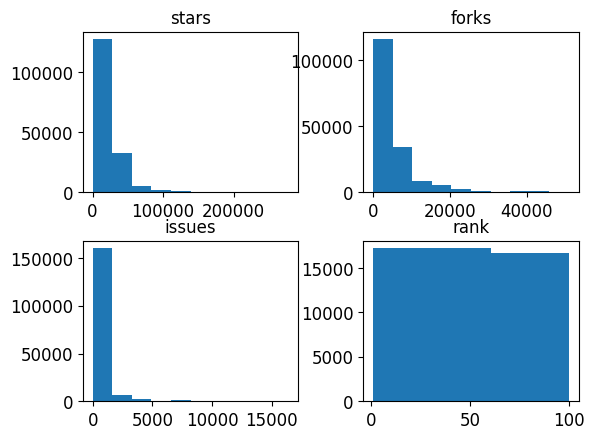

In [19]:
#distribución de las columnas númericas
numerical_col = list(df_cardinalidad["Tipo de dato"][df_cardinalidad["Tipo de dato"] == "numerical"].index)
df[numerical_col].hist(grid=False)

array([[<Axes: title={'center': 'last_commit'}>,
        <Axes: title={'center': 'date'}>]], dtype=object)

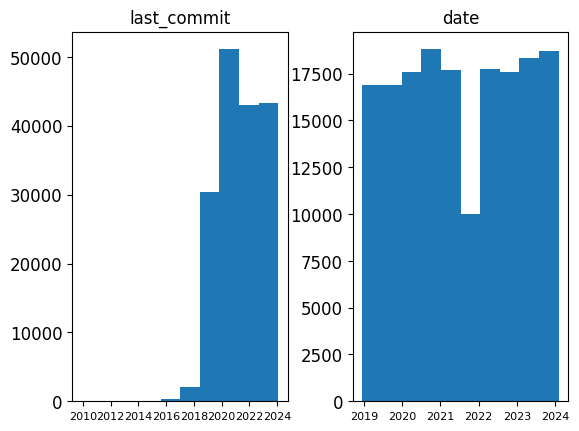

In [20]:
# distribución de las columnas datetime
df[["last_commit", "date"]].hist(grid=False, xlabelsize=(8))

([], [])

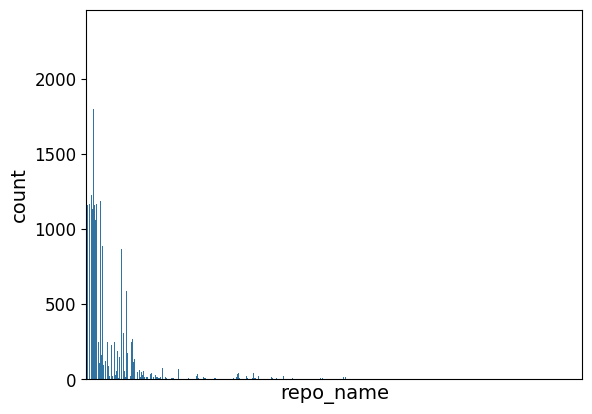

In [21]:
# distribución repo_name
sns.countplot(df, x = "repo_name")
plt.xticks([])

([], [])

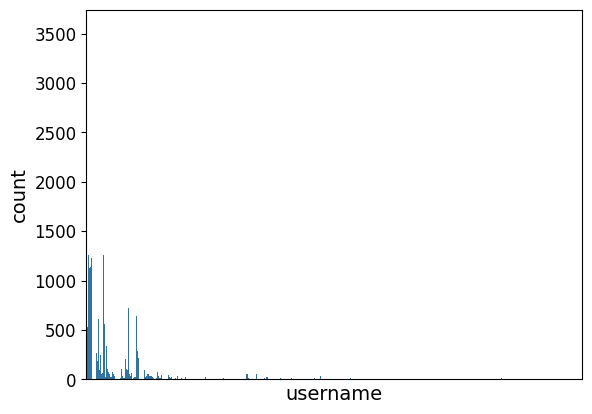

In [22]:
# distribución username
sns.countplot(df, x = "username")
plt.xticks([])

([], [])

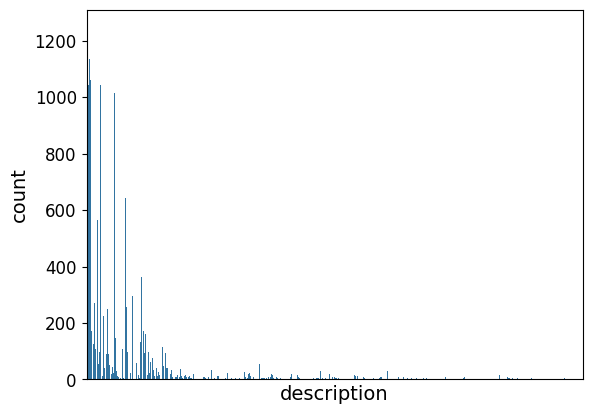

In [23]:
# distribución descripción
sns.countplot(df, x = "description")
plt.xticks([])

Conclusiones del análisis univariante:
- Ninguna variable se ajusta a la normal, la distribución de todas ellas difiere bastante de una campana gaussiana, por lo tanto no procedimos a realizar comprobaciones estadísticas.
- La mayoría de variables tienden a tener una cola hacia la izquierda, lo que indica que hay muchos valores que se repiten poco y probablemente algún outlier o valor atípico muy por encima de la media/moda/mediana.
- La única variable distribuida homogeneamente es la variable *rank*. Pero aún así se observa que hay más valor en el ranking por debajo de 75.
- La variable *last commit* es la única con una cola hacia la derecha, puede deberse a que al ser una variable temporal según se ha ido actualizando el dataset ha ido recogiendo mas información sobre los commits hechos.
- Nuestra variable target, *forks*, presenta una cola a la izquierda con un pequeño repunte entorno a los 40000.

### Análisis bivariante

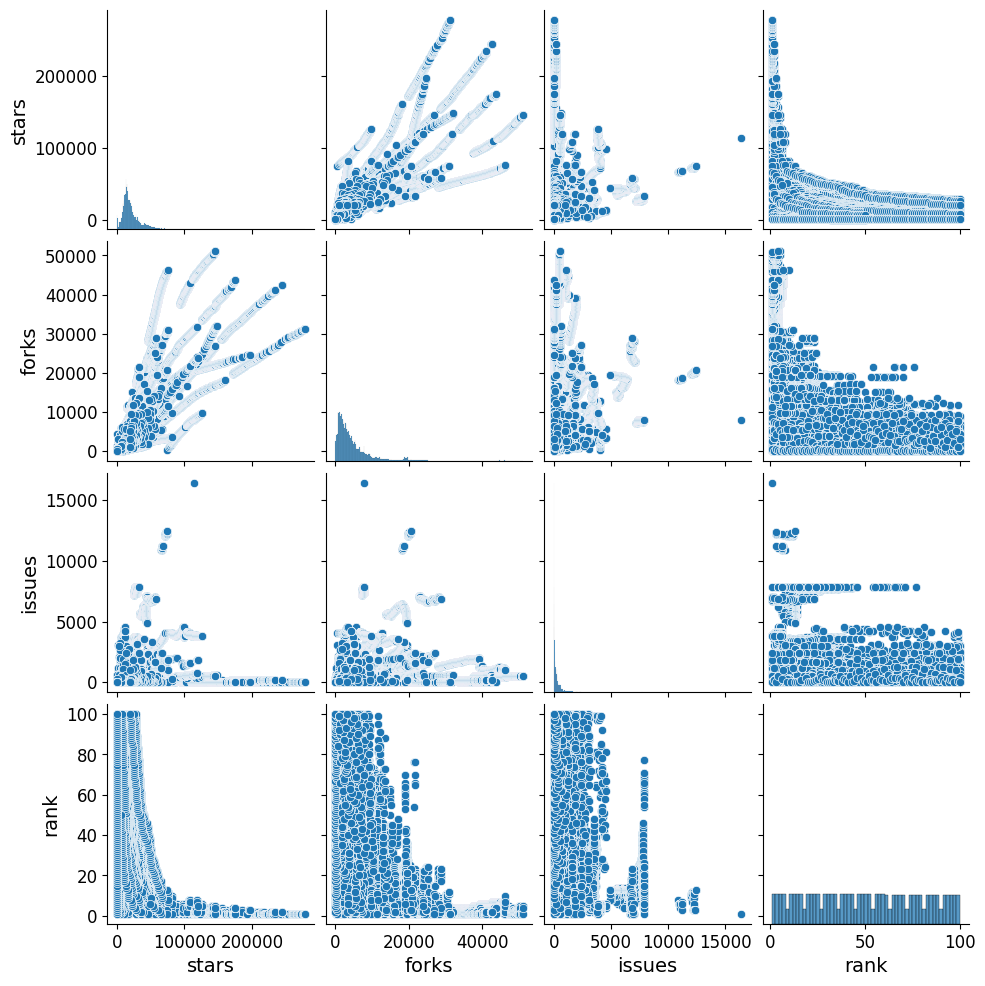

In [24]:
sns.pairplot(df[numerical_col])

<Axes: >

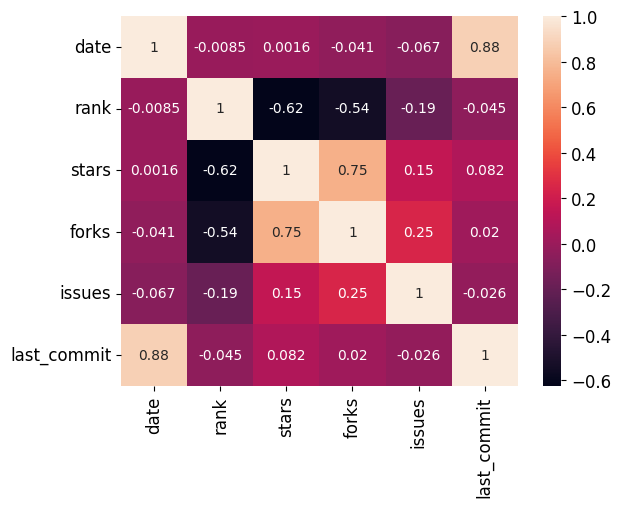

In [25]:
sns.heatmap(df[['date', 'rank', 'stars', 'forks', 'issues',
       'last_commit']].corr(), annot=True)

El análisis bivariante so se va a relizar con las columnas que presentan una gran correlación con la target mientras que el resto se añadirán al análisis multivariante.

- Destacamos la correlación de *forks* con *stars* y con *top*/*rank*.
- También cabe destacar la correlación entre sí de las variables previamente mentadas por su correlación con la target.
- Otra correlación que llama la atención es entre las variables *date* y *last_commit*. Es posible colinealidad.

Además, vamos a crear dos columnas nuevas momentáneamente para facilitar el proceso de graficado. Una que agrupará las filas de 20 en 20 según ranking y otra que agrupará las filas por el año de entrada. 

In [26]:
# agrupación rank -> top
df_1 = df.copy()

df_1["top"] = range(len(df_1))

#top20
df_1["top"].loc[list(df_1[df_1["rank"] <= 20].index)] = 20

#top40
top_20_mas = list(df_1[df_1["rank"] > 20].index)
top_40_menos = list(df_1[df_1["rank"] < 41].index)
top_20_40 = [x for x in top_20_mas if x in top_40_menos]
df_1["top"].loc[top_20_40] = 40

#top60
top_40_mas = list(df_1[df_1["rank"] > 40].index)
top_60_menos = list(df_1[df_1["rank"] < 61].index)
top_40_60 = [x for x in top_40_mas if x in top_60_menos]
df_1["top"].loc[top_40_60] = 60

#top80
top_60_mas = list(df_1[df_1["rank"] > 60].index)
top_80_menos = list(df_1[df_1["rank"] < 81].index)
top_60_80 = [x for x in top_60_mas if x in top_80_menos]
df_1["top"].loc[top_60_80] = 80


#top100
top_100 = list(df_1[df_1["rank"] > 80].index)
df_1["top"].loc[top_100] = 100

df_1["top"].value_counts()

top
20     34440
40     34440
60     34440
80     33480
100    33480
Name: count, dtype: int64

In [27]:
#agrupación años date
df_1["year"] = df_1["date"].dt.year
df_1["year"].value_counts()

year
2023    36120
2020    35500
2022    34360
2019    32900
2021    26800
2024     3300
2018     1300
Name: count, dtype: int64

In [28]:
## agrupando por años last commit
df_1["lc_year"] = df_1["last_commit"].dt.year
df_1["lc_year"].value_counts()

lc_year
2020    36193
2022    35929
2019    33705
2023    29673
2021    28106
2018     3173
2024     1555
2017     1449
2016      301
2015      108
2014       42
2013       30
2012       14
2011        1
2009        1
Name: count, dtype: int64

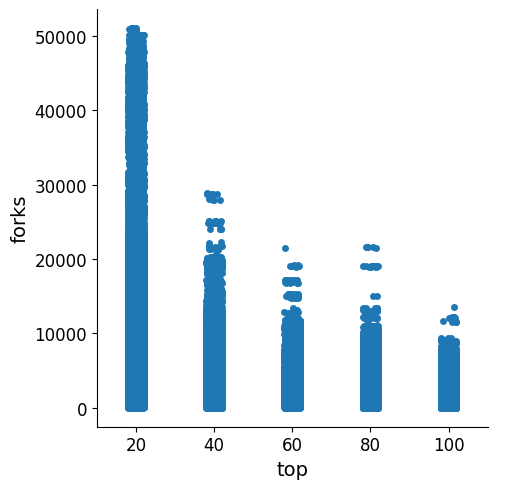

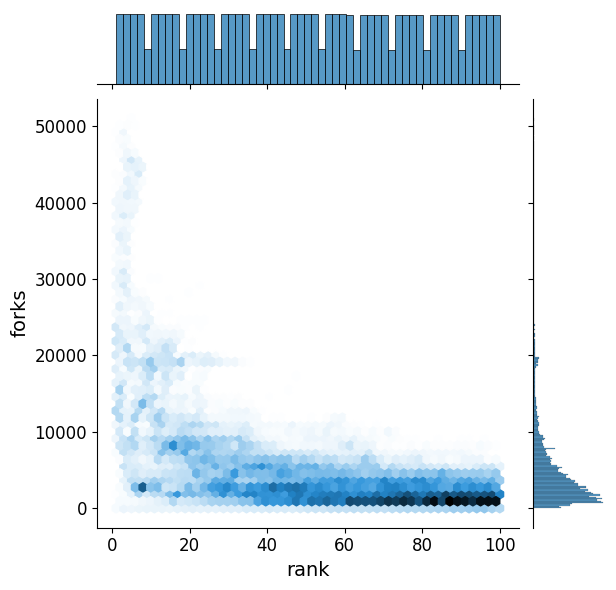

In [29]:
# forks y top/rank
sns.catplot(df_1, y= "forks", x ="top")
sns.jointplot(df_1, y= "forks", x ="rank", kind="hex")

<Axes: xlabel='stars', ylabel='forks'>

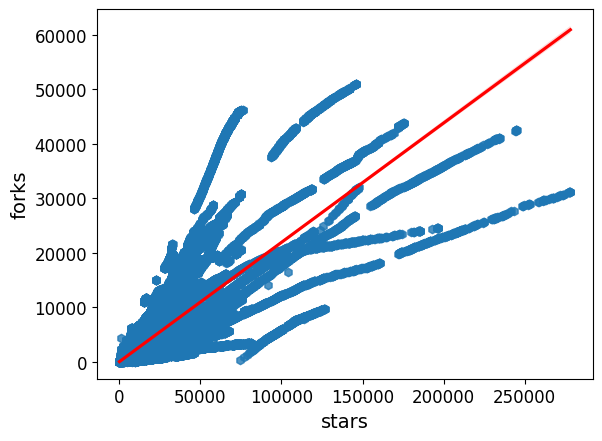

In [30]:
#stars y forks

sns.regplot(df_1, x="stars", y="forks", line_kws=dict(color="r"), marker="h")

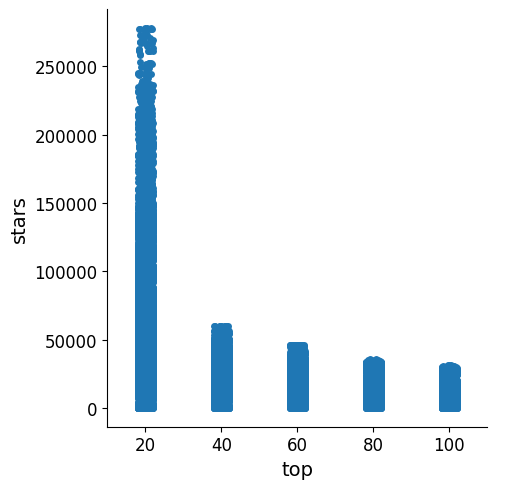

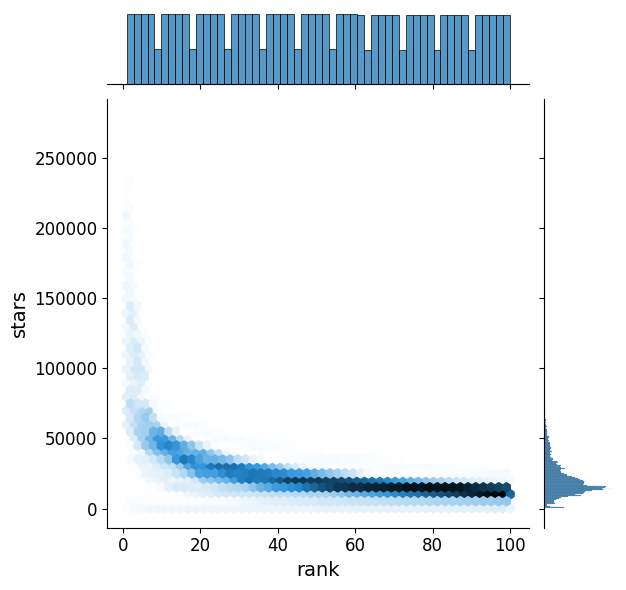

In [31]:
#stars y top/rank

sns.catplot(df_1, y= "stars", x ="top")
sns.jointplot(df_1, y= "stars", x ="rank", kind="hex")

### Análisis Multivariante

<Axes: xlabel='stars', ylabel='forks'>

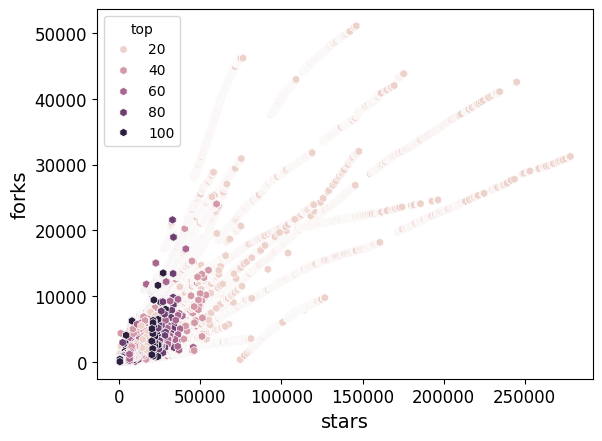

In [32]:
#stars-forks-top

sns.scatterplot(df_1, x="stars", y="forks", marker="h", hue="top")

<Axes: xlabel='year', ylabel='forks'>

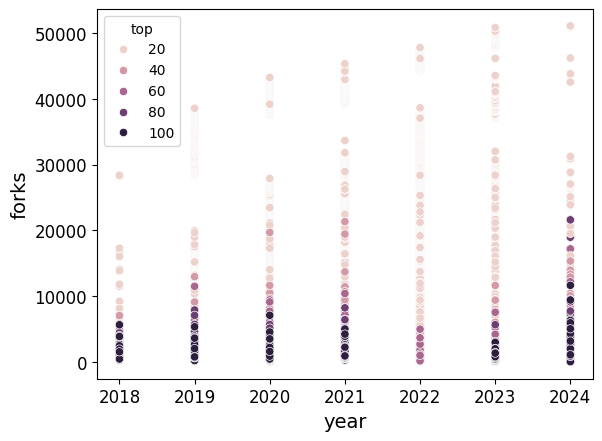

In [33]:
#stars - forks - top
sns.scatterplot(df_1, x="year", y="forks", hue="top")

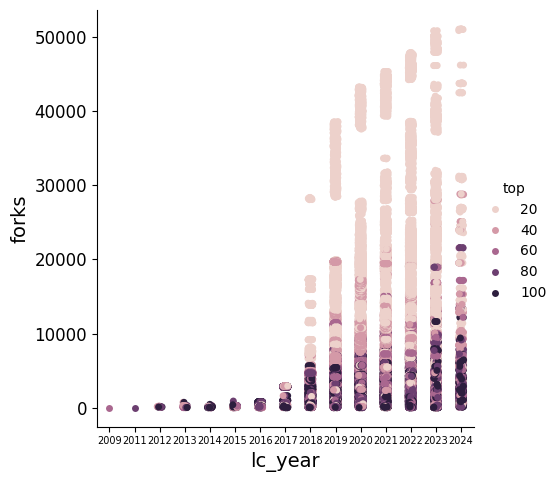

In [34]:
# last_commit, forks, top
sns.catplot(df_1, x="lc_year", y="forks", hue="top")
plt.xticks(size = 7);

Conclusiones del análisis multivariante:
- Cuantas más alto en el ranking y más estrellas tenga un repositorio, más forks se hacen del mismo.
- Pese a que no haya una fuerte correlación, se puede observar cierta tendencia en la cual tanto en la fecha de adición de la entrada al dataset, como el último commit a dicho repositorio influyen en el ranking y por lo tanto en la cantidad de forks realizados.

### Conclusiones generales tras la primera exploración y el EDA

El dataset está bastante limpio y excepto las columnas categóricas, el resto no necesitan demasiado preprocesamiento.

Las variables numéricas a priori mas importantes, con mas correlación con nuestra variable target (*forks*), son *stars* y *rank*. Tiene sentido pues cuanto mejor valorado esté, y más popular sea el repositorio, más forks debería tener.

Por último, pese a la poca correlación que existe entre las variables *last_commit* y *date* con el target, se observa un patrón en ambas variables que indica que cuanto mas cerca del presente este la fecha de subida de la entrada y el último commit, tiende a tener mas forks. Además se puede intuir cierta colinealidad entre las dos variables.

Sobre las variables categóricas, una vez sean tratadas podremos analizarlas.

## 2. Limpieza

### Valores nulos

Como vimos en la exploración incial, el único feature con valores nulos es *description*. Al ser menos de un 1% de los datos y además una variable imposible de imputar, procedemos a eliminar estos valores nulos.

In [35]:
df.dropna(axis=0, inplace=True)

In [36]:
df.shape

(168687, 9)

### Valores Atípicos y outliers

Tras lo visto en el EDA, no existen valores atípicos (imposibles o incoherentes). En cuanto a los outliers, se siente que estos valores aportan mas información útil que ruido, por lo tanto se van a mantener. 

## 3. Feature Engineering

### days since last commit

En este apartado, vamos a crear un nuevo feature *days since last commit (days_since_lc)*. Ya que en el EDA observamos que pese a la poca correlación entre la variable *last_commit* y la target, se observaba cierta tendencia ascendente entre la cantida de forks y la proximidad con el presente del último commit. Con este nuevo feature, pretedemos mantener esa información mientras se evita la posible colinealidad que existe entre las variables *last_commmit* y *date*.

In [37]:
# Ajustando el formato de last commit a date 
lc_y_m_d = [x[0] for x in df["last_commit"].astype(str).str.split(" ")]
df["last_commit"] = lc_y_m_d
df["last_commit"] = pd.to_datetime(df["last_commit"])

# Creando el feature nuevo
df["days_since_lc"] = (df["date"] - df["last_commit"]) / timedelta(days=1)
df.head() 

,date,rank,repo_name,stars,forks,username,issues,last_commit,description,days_since_lc
0,2018-12-18,1,awesome-python,58777,11448,vinta,439,2018-12-13,"A curated list of awesome Python frameworks, l...",5.0
1,2018-12-18,2,system-design-primer,53575,7570,donnemartin,68,2018-12-18,Learn how to design large-scale systems. Prep ...,0.0
2,2018-12-18,3,models,46039,28053,tensorflow,1324,2018-12-18,Models and examples built with TensorFlow,0.0
3,2018-12-18,4,public-apis,45373,4707,toddmotto,5,2018-12-18,A collective list of free APIs for use in soft...,0.0
4,2018-12-18,5,youtube-dl,44956,7820,rg3,2566,2018-12-18,Command-line program to download videos from Y...,0.0


Ahora procederemos a realizar un pequeño análisis exploratorio de esta columna nueva.

<Axes: >

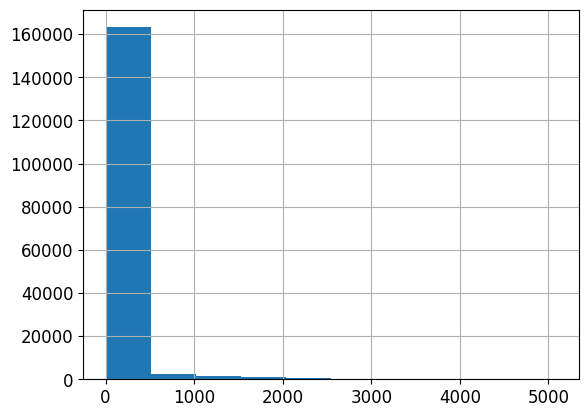

In [38]:
df["days_since_lc"].hist()

<Axes: xlabel='days_since_lc', ylabel='forks'>

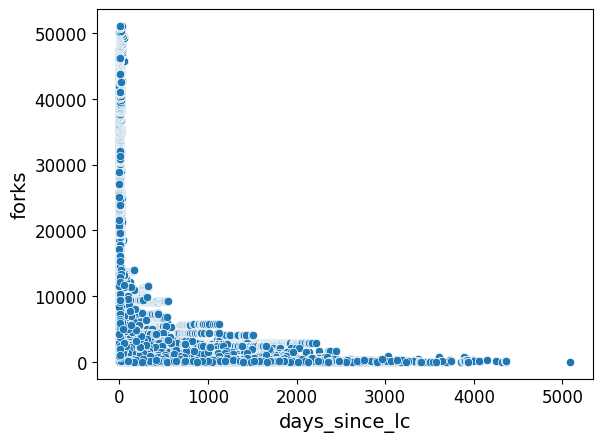

In [39]:
sns.scatterplot(df, x ="days_since_lc", y="forks")

<Axes: >

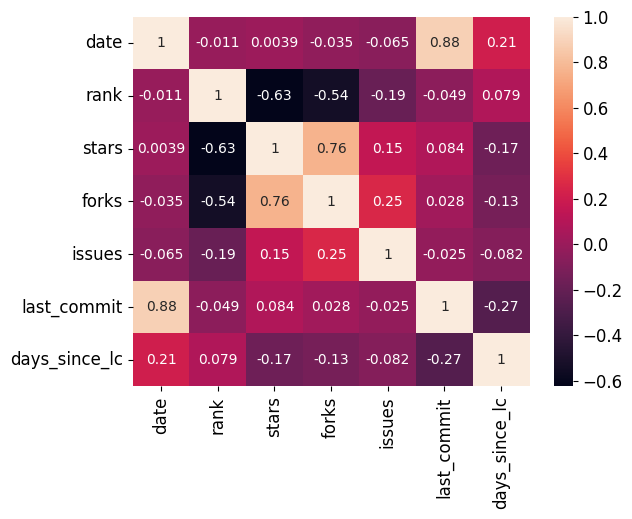

In [40]:
sns.heatmap(df.select_dtypes(exclude='O').corr(), annot=True)

Se puede observar en las gráficas que *days_since_lc* tiene un comportamiento y similar a *last_commit* y ademas hemos eliminado la posible colinealidad con la variable *date*. Por lo tanto vamos a eliminar el feature *last_commit*. 

In [41]:
df.drop(columns="last_commit", inplace=True)

### repos_by_user

La columna *username* es una variable categórica, con información sobre el autor del repositorio. Como vimos en la exploración inicial, no coincide el número de users con el la cantidad de repositorios únicos, por lo tanto tiene que haber autores con mas de un repostorio. El trabajo de feature engineering que vamos a hacer con esta variable es crear una columna la cual nos indique si es un repostorio de un autor "famoso".

In [42]:
# Comprobando que haya usuarios con más de un repositorio
df.groupby("username")["repo_name"].value_counts()

username   repo_name                   
0k         shyaml                             1
0rpc       zerorpc-python                     1
0voice     interview_internal_reference     988
0x5e       wechat-deleted-friends             2
0xAX       linux-insides                   1134
                                           ... 
zulip      zulip                            615
zyantific  IDASkins                           1
zygmuntz   hyperband                          1
           phraug                             1
zzw922cn   Automatic_Speech_Recognition       1
Name: count, Length: 4265, dtype: int64

In [43]:
#usuarios con más de un repo
popular_users = list(df["username"].value_counts()[df["username"].value_counts() > 1].index)

#usuarios por repositorio
n_repos = [df[df["username"] == x]["repo_name"].nunique() for x in popular_users]

# Creando la columna repos_by_user
df = pd.merge(df, pd.DataFrame({'username':popular_users, 'repos_by_user':n_repos}), 'outer', on='username')

# rellenando lo NaNs que quedará, que son para los usuarios con solo un repositorio
df["repos_by_user"].fillna(1, inplace=True)

<Axes: >

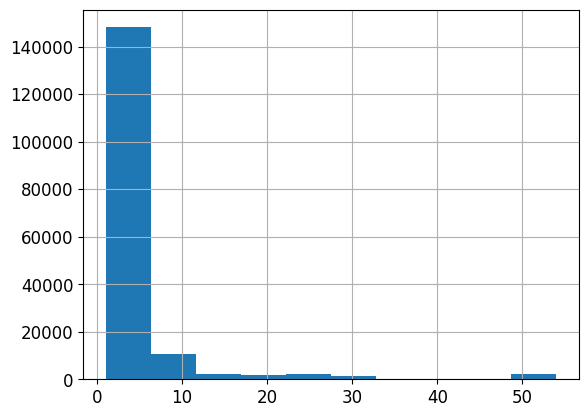

In [44]:
df["repos_by_user"].hist()

<Axes: xlabel='repos_by_user', ylabel='forks'>

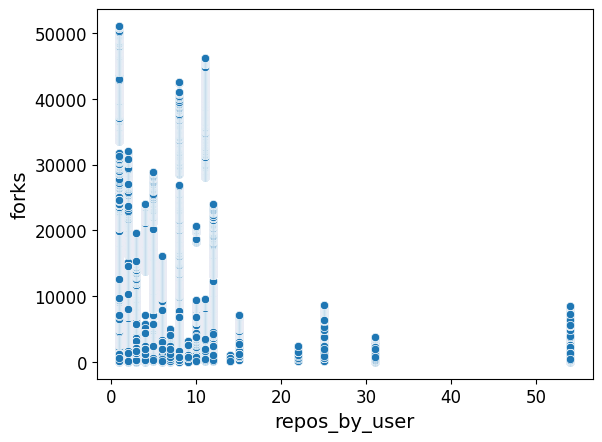

In [45]:
sns.scatterplot(df, x ="repos_by_user", y="forks")

Tras haber creado la columna *repos_by_user* y haber hecho un pequeño análisis exploratorio de la misma, se ve que existe cierta relación inversa entre el número de forks y los repositorios en el top del autor. Aún así, sigue quedando la duda de si el propio nombre del autor influye.

## 4. Tranformaciones y escalado

### Análisis de sentimiento

Para poder extraer mas información de la descripción, vamos a realizar la un análisi de sentimientos de la misma utilizando la libreria NLTK.

In [48]:
# Instanciando el análisis de sentimiento
sia = SentimentIntensityAnalyzer()

# Creando las columnas de análisis de sentimiento
res = {}

for i, x in df.iterrows():
    des = x["description"]
    repo_name = x["repo_name"]
    res[repo_name] = sia.polarity_scores(des)

vaders = pd.DataFrame(res).T

vaders.head()

,neg,neu,pos,compound
shyaml,0.0,1.0,0.0,0.0
zerorpc-python,0.0,1.0,0.0,0.0
interview_internal_reference,0.0,1.0,0.0,0.0
wechat-deleted-friends,0.0,1.0,0.0,0.0
linux-insides,0.0,1.0,0.0,0.0


In [49]:
# añadiendo vaders a nuestro DataFrame
vaders = vaders.reset_index().rename(columns={"index":"repo_name"})
df = df.merge(vaders, how="left")
df.head()

,date,rank,repo_name,stars,forks,username,issues,description,days_since_lc,repos_by_user,neg,neu,pos,compound
0,2023-08-09,50,shyaml,750,57,0k,13,YAML for command line,115.0,1.0,0.0,1.0,0.0,0.0
1,2023-11-20,54,zerorpc-python,3115,416,0rpc,46,zerorpc for python,61.0,1.0,0.0,1.0,0.0,0.0
2,2019-07-23,92,interview_internal_reference,10536,2730,0voice,7,2019年最新总结，阿里，腾讯，百度，美团，头条等技术面试题目，以及答案，专家出题人分析汇总。,0.0,1.0,0.0,1.0,0.0,0.0
3,2019-07-25,62,interview_internal_reference,12382,3284,0voice,6,2019年最新总结，阿里，腾讯，百度，美团，头条等技术面试题目，以及答案，专家出题人分析汇总。,2.0,1.0,0.0,1.0,0.0,0.0
4,2019-07-27,71,interview_internal_reference,13024,3470,0voice,7,2019年最新总结，阿里，腾讯，百度，美团，头条等技术面试题目，以及答案，专家出题人分析汇总。,1.0,1.0,0.0,1.0,0.0,0.0


Ahora vamos a realizar un pequeño análisis exploratorio de las columnas que hemos añadido.

<Axes: xlabel='compound', ylabel='Count'>

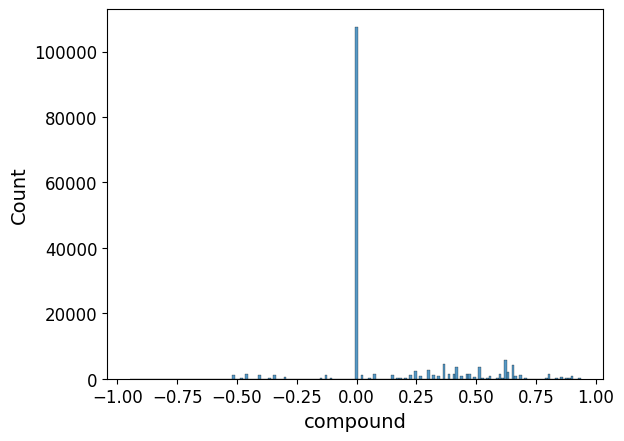

In [50]:
sns.histplot(df, x = "compound")

<Axes: xlabel='neu', ylabel='Count'>

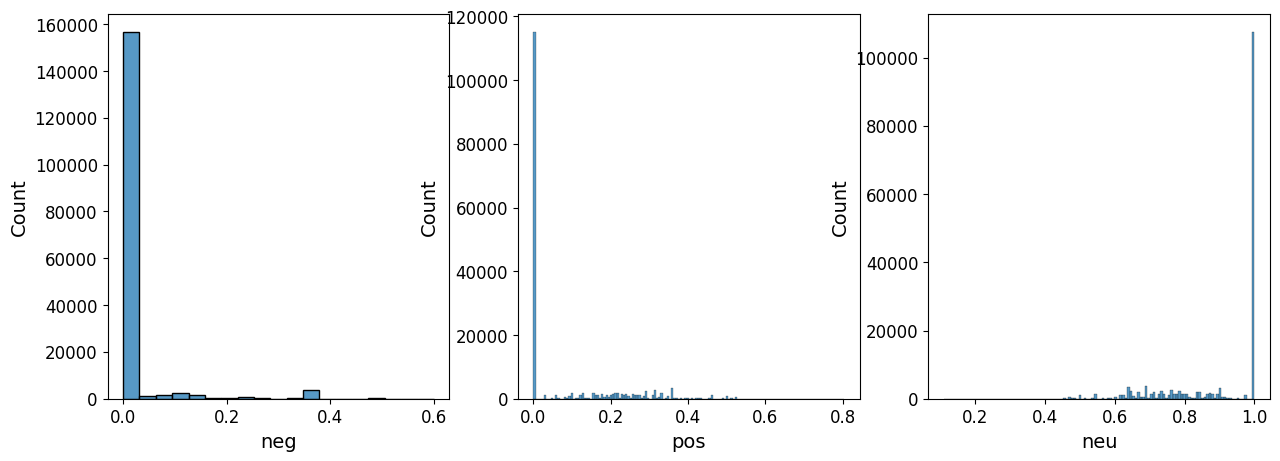

In [51]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))

sns.histplot(df, x = "neg", ax=axs[0])
sns.histplot(df, x = "pos", ax=axs[1])
sns.histplot(df, x = "neu", ax=axs[2])

<Axes: >

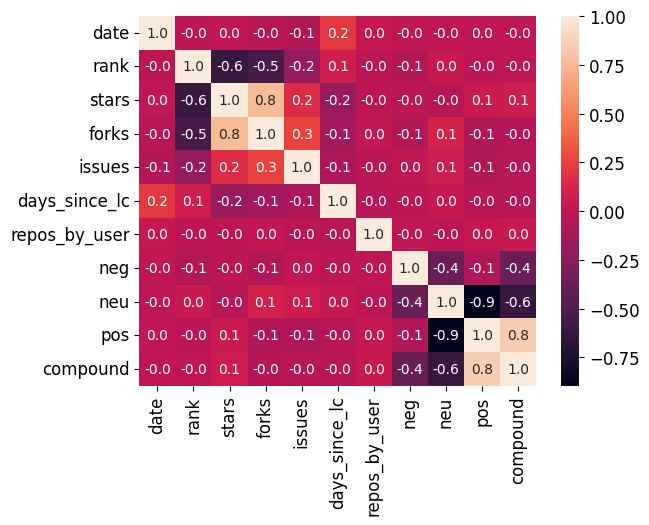

In [52]:
sns.heatmap(df.select_dtypes(exclude='O').corr(), annot=True, fmt=".1f")

Observamos que las columnas de sentimiento tienen mucha correlación entre ellas, por ello nos vamos a quedar solo con *compound* puesto que es una aglomeración de las 3. 

In [53]:
df.drop(columns=['neg', 'neu', 'pos'], inplace=True)

<Axes: xlabel='compound', ylabel='forks'>

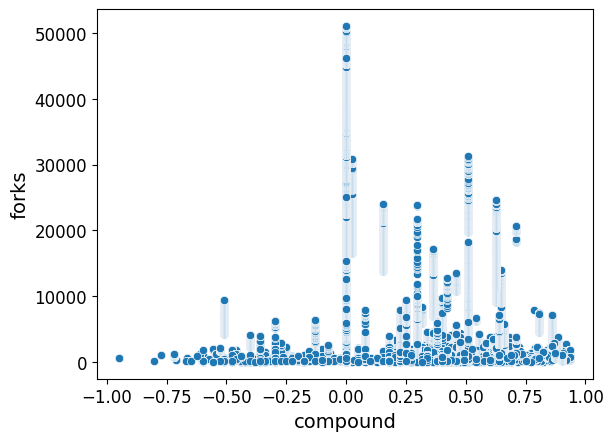

In [54]:
sns.scatterplot(df, x ="compound", y="forks")

### Label Encoder

Vamos a tranformar las dos columnas que quedan utilizando el método label encoder, puesto que crear dummies es inviable con la cantidad de únicos que tienen.

In [55]:
le = LabelEncoder()

for x in df[["repo_name", "description", "username"]].columns:
    df[x] = le.fit_transform(df[x])

df.head()

,date,rank,repo_name,stars,forks,username,issues,description,days_since_lc,repos_by_user,compound
0,2023-08-09,50,3536,750,57,0,13,3871,115.0,1.0,0.0
1,2023-11-20,54,4136,3115,416,1,46,4184,61.0,1.0,0.0
2,2019-07-23,92,2381,10536,2730,2,7,59,0.0,1.0,0.0
3,2019-07-25,62,2381,12382,3284,2,6,59,2.0,1.0,0.0
4,2019-07-27,71,2381,13024,3470,2,7,59,1.0,1.0,0.0


## Escalado

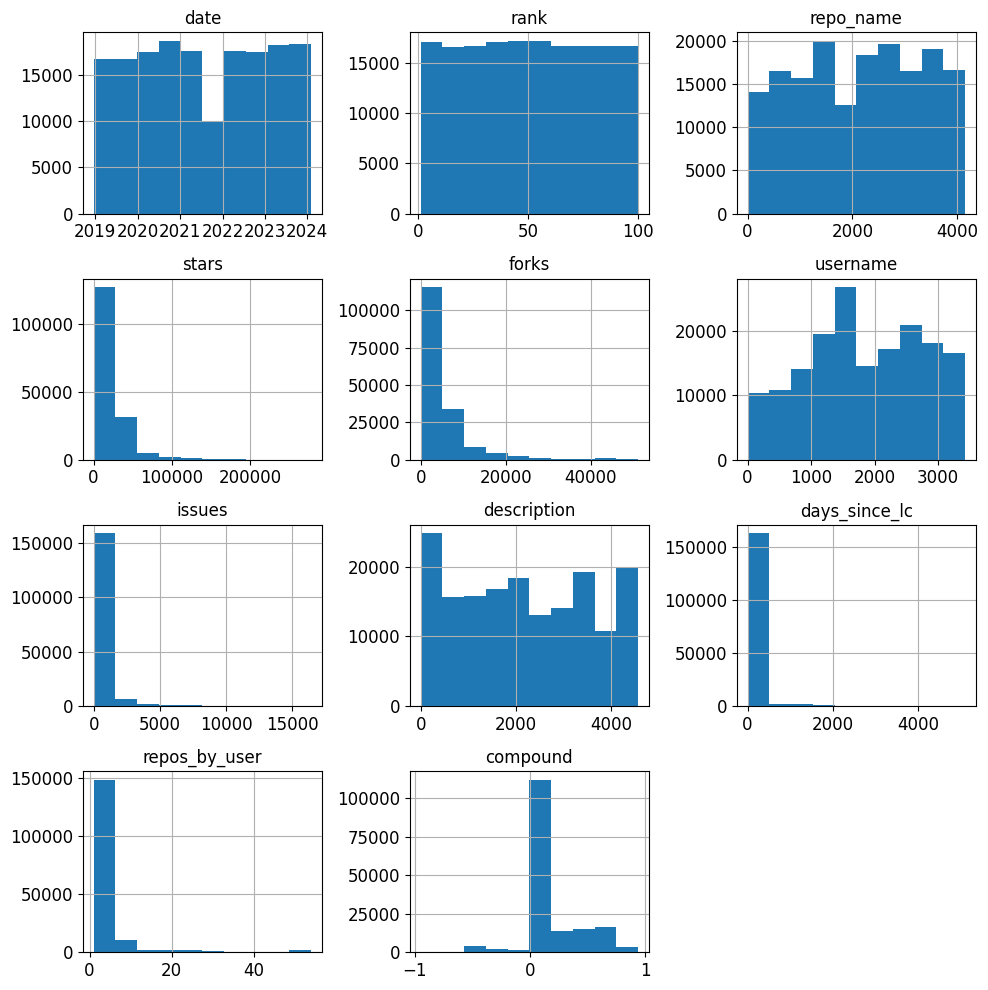

In [56]:
df.hist(figsize=(10,10))
plt.tight_layout()

Debido a las características de los features (no se ajustan a la normal, son variables discretas y hay outliers), el escalado será realizado mediante el método ``RobustScaler``.

In [57]:
# Prerando la columna Date para poder escalarla
df["day"] = df["date"].dt.day
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

df.drop(columns="date", inplace=True)

In [58]:
#Escalado
RobEsc = RobustScaler()

esc_features = RobEsc.fit_transform(df)

df[['rank', 'repo_name', 'stars', 'forks', 'username', 'issues',
       'description', 'days_since_lc', 'repos_by_user', 'compound', 'day',
       'month', 'year']] = esc_features

In [59]:
df

,rank,repo_name,stars,forks,username,issues,description,days_since_lc,repos_by_user,compound,day,month,year
0,0.000000,0.625844,-1.184326,-0.707295,-1.203413,-0.354651,0.658838,6.222222,0.0,0.000000,-0.466667,0.333333,1.0
1,0.081633,0.915140,-1.022450,-0.627447,-1.202730,-0.258721,0.783439,3.222222,0.0,0.000000,0.266667,0.833333,1.0
2,0.857143,0.068949,-0.514511,-0.112767,-1.202048,-0.372093,-0.858678,-0.166667,0.0,0.000000,0.466667,0.166667,-1.0
3,0.244898,0.068949,-0.388159,0.010454,-1.202048,-0.375000,-0.858678,-0.055556,0.0,0.000000,0.600000,0.166667,-1.0
4,0.428571,0.068949,-0.344216,0.051824,-1.202048,-0.372093,-0.858678,-0.111111,0.0,0.000000,0.733333,0.166667,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168682,-0.571429,0.921890,0.084736,0.879004,1.131058,4.497093,0.666799,-0.166667,0.0,2.151689,0.333333,-0.833333,1.5
168683,-0.204082,-0.867888,-1.175086,-0.684164,1.131741,-0.386628,-0.573248,73.666667,0.0,0.844595,-0.133333,-0.666667,1.0
168684,0.510204,0.364995,-1.217112,-0.686833,1.132423,-0.386628,-0.626990,132.277778,0.5,0.000000,-0.466667,0.666667,1.0
168685,-0.775510,0.035680,-1.195551,-0.703292,1.132423,-0.375000,0.582803,106.222222,0.5,0.000000,-0.266667,0.833333,1.0


## 5. Clusterización

Vamos a utilizar un modelo no supervidado como preprocesamiento para poder ajustar mejor las predicciones. En este caso nos hemos decantado por el ``kmeans-minibatch`` ya que nos facilitará el proceso de computación.

In [60]:
# quitamos la target

df_cluster = df.drop(columns="forks") 

# Buscando el K óptimo
kmeans_per_k = [MiniBatchKMeans(n_clusters=k, random_state=42).fit(df_cluster)
                for k in range(2, 21)]
inertias = [model.inertia_ for model in kmeans_per_k]

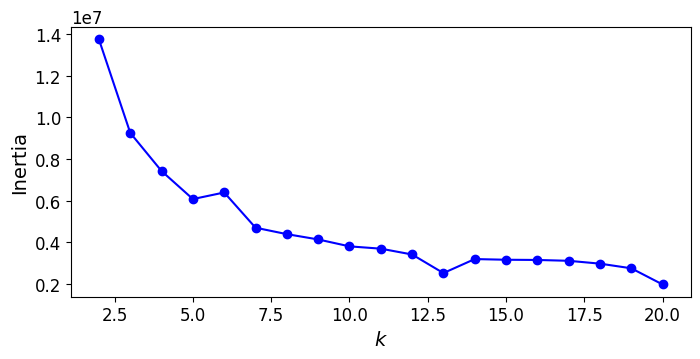

In [61]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 21), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)


plt.show()

El kmeans óptimo es k=5.

In [62]:
# Instanciamos el modelo
kmeans = MiniBatchKMeans(5, random_state=42).fit(df_cluster)

In [63]:
# Añadimos los cluster al df
clusterized = kmeans.predict(df_cluster)
df_cluster["forks"] = df["forks"]
df_cluster["cluster_result"] = clusterized

df_cluster.head()

,rank,repo_name,stars,username,issues,description,days_since_lc,repos_by_user,compound,day,month,year,forks,cluster_result
0,0.000000,0.625844,-1.184326,-1.203413,-0.354651,0.658838,6.222222,0.0,0.0,-0.466667,0.333333,1.0,-0.707295,4
1,0.081633,0.915140,-1.022450,-1.202730,-0.258721,0.783439,3.222222,0.0,0.0,0.266667,0.833333,1.0,-0.627447,0
2,0.857143,0.068949,-0.514511,-1.202048,-0.372093,-0.858678,-0.166667,0.0,0.0,0.466667,0.166667,-1.0,-0.112767,0
3,0.244898,0.068949,-0.388159,-1.202048,-0.375000,-0.858678,-0.055556,0.0,0.0,0.600000,0.166667,-1.0,0.010454,0
4,0.428571,0.068949,-0.344216,-1.202048,-0.372093,-0.858678,-0.111111,0.0,0.0,0.733333,0.166667,-1.0,0.051824,0


In [64]:
# Separamos por cluster para hacer un modelo por cada uno
df_cluster_0 = df_cluster[df_cluster["cluster_result"] == 0]
df_cluster_1 = df_cluster[df_cluster["cluster_result"] == 1]
df_cluster_2 = df_cluster[df_cluster["cluster_result"] == 2]
df_cluster_3 = df_cluster[df_cluster["cluster_result"] == 3]
df_cluster_4 = df_cluster[df_cluster["cluster_result"] == 4]

## 6. Modelo Cluster 0

### Separación de los datos

In [65]:
# Separación en train y test
train_0, test_0 = train_test_split(df_cluster_0, test_size=0.2, random_state=42)

# Separación en train y val
X = train_0.drop(columns="forks")
y = train_0["forks"]

X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=42)

### BaseLines

In [66]:
# modelos
modelos = {
    "LinearRegression": LinearRegression(),
    "ElasticNet": ElasticNet(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "GradientBoost": GradientBoostingRegressor(),
    "HistGradientBoosting": HistGradientBoostingRegressor()
}

# Define las métricas a usar
metricas = "r2"

resultados_dict = {}

for modelo in modelos:

    resultados_dict[modelo] = [cross_val_score(modelos[modelo], X_train, y_train, scoring="r2", cv=3).mean()]

#resultado
pd.DataFrame(resultados_dict).T.rename(columns={0:"Score"})

,Score
LinearRegression,0.624881
ElasticNet,0.487021
Ridge,0.624881
Lasso,0.384551
DecisionTree,0.999008
RandomForest,0.999514
AdaBoost,0.766904
GradientBoost,0.952159
HistGradientBoosting,0.993810


Los modelos con mejor score son el árbol de decisión, random forest y HGB. Vamos a decidir entre los tres mediante un ``Voting``.

In [67]:
# Instanciando el voting
VotingR = VotingRegressor(estimators=
                          [
                              ("dt", DecisionTreeRegressor(random_state=42)),
                              ("hgb", HistGradientBoostingRegressor(random_state=42)),
                              ("rf", RandomForestRegressor(random_state=42))
                          ])
# Entrenando el voting
VotingR.fit(X_train, y_train)

#monstrando resultados
for name, clf in VotingR.named_estimators_.items():
    print(name, "=", clf.score(X_val, y_val))

dt = 0.9989934212063188
hgb = 0.9937171665285558
rf = 0.9996108109430827


Elegimos el árbol de decisión puesto que su score es similar a los otros dos y es el más fácil de explicar.

### Optimización y entrenamiento

In [68]:
# parámetros a evaluar
param_grid = {
    'max_depth': [0, 1, 2, 3, 4, 5],
    'min_samples_leaf': np.arange(1,10),
    'max_features': np.arange(2,12),
    'splitter':["best", "random"], 
    'min_samples_leaf': np.arange(2,5)
    

}

# modelo
decicsion_tree_r = DecisionTreeRegressor(random_state=42)

# gridsearch
grid_search = GridSearchCV(decicsion_tree_r,
                           param_grid,
                           cv=5,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1
                          )

# Entrenamiento
grid_search.fit(X_train, y_train)

# instanciando modelo entrenado en una variable
dtr = grid_search.best_estimator_

# mostrando mejores valores

print(grid_search.best_params_)

{'max_depth': 5, 'max_features': 11, 'min_samples_leaf': 2, 'splitter': 'best'}


### Métricas y validación

Vamos a realizar una prediccion para ver como se ajusta el modelo a los valores de validación.

In [69]:
pred = dtr.predict(X_val)

print("train r2:", r2_score(y_val, pred))
print('val r2:', r2_score(y_val, pred))
print("MAE:", mean_absolute_error(y_val, pred))
print("MSE:", mean_squared_error(y_val, pred))
print("MAPE:", mean_absolute_percentage_error(y_val, pred))

train r2: 0.8648177195665906
val r2: 0.8648177195665906
MAE: 0.38250207258364044
MSE: 0.3051539078954347
MAPE: 34271978306.29895


El modelo se ajusta correctamente a los datos de validación.

### Test

In [70]:
# Separando en x_test e y_test
X_test = test_0.drop(columns="forks")
y_test = test_0["forks"]

In [71]:
# Métricas del test
pred_test = dtr.predict(X_test)
print("r2:", r2_score(y_test, pred_test))
print("MAE:", mean_absolute_error(y_test, pred_test))
print("MSE:", mean_squared_error(y_test, pred_test))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_test))

r2: 0.8644547498843949
MAE: 0.3858343046944803
MSE: 0.3061147517151832
MAPE: 162564482877.08176


In [72]:
# Viendo como se ajusta el modelo
print('train', r2_score(y_train, dtr.predict(X_train)))
print('val', r2_score(y_val, pred))
print('test', r2_score(y_test, pred_test))

train 0.8629127529798707
val 0.8648177195665906
test 0.8644547498843949


El modelo no pierde eficacia tras pasarle los datos de test, por lo tanto es un modelo listo para usarse.

## 7. Modelo Cluster 1

### Separación de datos

In [73]:
# Separación en train y test
train_1, test_1 = train_test_split(df_cluster_1, test_size=0.2, random_state=42)

# Separación en train y val
X = train_1.drop(columns="forks")
y = train_1["forks"]

X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=42)

### BaseLines

In [74]:
# modelos
modelos = {
    "LinearRegression": LinearRegression(),
    "ElasticNet": ElasticNet(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "GradientBoost": GradientBoostingRegressor(),
    "HistGradientBoosting": HistGradientBoostingRegressor()
}

# Define las métricas a usar
metricas = "r2"

resultados_dict = {}

for modelo in modelos:

    resultados_dict[modelo] = [cross_val_score(modelos[modelo], X_train, y_train, scoring="r2", cv=3).mean()]

#resultado
pd.DataFrame(resultados_dict).T.rename(columns={0:"Score"})

,Score
LinearRegression,0.914744
ElasticNet,0.116249
Ridge,0.914561
Lasso,0.098906
DecisionTree,0.972287
RandomForest,0.982173
AdaBoost,0.967949
GradientBoost,0.979074
HistGradientBoosting,0.981380


Los modelos con mejor score son el árbol de decisión, random forest y HGB. Vamos a decidir entre los tres mediante un ``Voting``.

In [75]:
# Instanciando el voting
VotingR = VotingRegressor(estimators=
                          [
                              ("dt", DecisionTreeRegressor(random_state=42)),
                              ("hgb", HistGradientBoostingRegressor(random_state=42)),
                              ("rf", RandomForestRegressor(random_state=42))
                          ])
# Entrenando el voting
VotingR.fit(X_train, y_train)

#monstrando resultados
for name, clf in VotingR.named_estimators_.items():
    print(name, "=", clf.score(X_val, y_val))

dt = 0.9747690813769797
hgb = 0.9819206988060246
rf = 0.9828786067206712


Elegimos el árbol de decisión puesto que su score es similar a los otros dos y es el más fácil de explicar.

### Optimización y entrenamiento

In [76]:
# parámetros a evaluar
param_grid = {
    'max_depth': [0, 1, 2, 3, 4, 5],
    'min_samples_leaf': np.arange(1,10),
    'max_features': np.arange(2,12),
    'splitter':["best", "random"], 
    'min_samples_leaf': np.arange(2,5)
    

}

# modelo
decicsion_tree_r = DecisionTreeRegressor(random_state=42)

# gridsearch
grid_search = GridSearchCV(decicsion_tree_r,
                           param_grid,
                           cv=5,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1
                          )

# Entrenamiento
grid_search.fit(X_train, y_train)

# instanciando modelo entrenado en una variable
dtr = grid_search.best_estimator_

# mostrando mejores valores

print(grid_search.best_params_)

{'max_depth': 5, 'max_features': 9, 'min_samples_leaf': 2, 'splitter': 'best'}


### Métricas y validación

Vamos a realizar una prediccion para ver como se ajusta el modelo a los valores de validación.

In [77]:
pred = dtr.predict(X_val)

print("train r2:", r2_score(y_val, pred))
print('val r2:', r2_score(y_val, pred))
print("MAE:", mean_absolute_error(y_val, pred))
print("MSE:", mean_squared_error(y_val, pred))
print("MAPE:", mean_absolute_percentage_error(y_val, pred))

train r2: 0.9497945275122595
val r2: 0.9497945275122595
MAE: 0.02403137199177132
MSE: 0.0019879766944487743
MAPE: 0.0448802650009475


El modelo se ajusta correctamente a los datos de validación.

### Test

In [78]:
# Separando en x_test e y_test
X_test = test_1.drop(columns="forks")
y_test = test_1["forks"]

In [79]:
# Métricas del test
pred_test = dtr.predict(X_test)
print("r2:", r2_score(y_test, pred_test))
print("MAE:", mean_absolute_error(y_test, pred_test))
print("MSE:", mean_squared_error(y_test, pred_test))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_test))

r2: 0.9794962324075995
MAE: 0.016834833374274213
MSE: 0.0008507663406894742
MAPE: 0.028014815639860698


In [80]:
# Viendo como se ajusta el modelo
print('train', r2_score(y_train, dtr.predict(X_train)))
print('val', r2_score(y_val, pred))
print('test', r2_score(y_test, pred_test))

train 0.9812629940045631
val 0.9497945275122595
test 0.9794962324075995


## 8. Modelo Cluster 2

### Separación de datos

In [81]:
# Separación en train y test
train_2, test_2 = train_test_split(df_cluster_2, test_size=0.2, random_state=42)

# Separación en train y val
X = train_2.drop(columns="forks")
y = train_2["forks"]

X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=42)

### BaseLines

In [82]:
modelos = {
    "LinearRegression": LinearRegression(),
    "ElasticNet": ElasticNet(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "GradientBoost": GradientBoostingRegressor(),
    "HistGradientBoosting": HistGradientBoostingRegressor()
}

# Define las métricas a usar
metricas = "r2"

resultados_dict = {}

for modelo in modelos:

    resultados_dict[modelo] = [cross_val_score(modelos[modelo], X_train, y_train, scoring="r2", cv=3).mean()]

#resultado
pd.DataFrame(resultados_dict).T.rename(columns={0:"Score"})

,Score
LinearRegression,0.713606
ElasticNet,-0.000047
Ridge,0.713556
Lasso,-0.000047
DecisionTree,0.973194
RandomForest,0.980341
AdaBoost,0.899642
GradientBoost,0.960068
HistGradientBoosting,0.978684


Los modelos con mejor score son el árbol de decisión, random forest y HGB. Vamos a decidir entre los tres mediante un ``Voting``.

In [83]:
# Instanciando el voting
VotingR = VotingRegressor(estimators=
                          [
                              ("dt", DecisionTreeRegressor(random_state=42)),
                              ("hgb", HistGradientBoostingRegressor(random_state=42)),
                              ("rf", RandomForestRegressor(random_state=42))
                          ])
# Entrenando el voting
VotingR.fit(X_train, y_train)

#monstrando resultados
for name, clf in VotingR.named_estimators_.items():
    print(name, "=", clf.score(X_val, y_val))

dt = 0.979605375814714
hgb = 0.986902818148142
rf = 0.9865483415626831


Elegimos el árbol de decisión puesto que su score es similar a los otros dos y es el más fácil de explicar.

### Optimización y entrenamiento

In [84]:
# parámetros a evaluar
param_grid = {
    'max_depth': [0, 1, 2, 3, 4, 5],
    'min_samples_leaf': np.arange(1,10),
    'max_features': np.arange(2,12),
    'splitter':["best", "random"], 
    'min_samples_leaf': np.arange(2,5)
    

}

# modelo
decicsion_tree_r = DecisionTreeRegressor(random_state=42)

# gridsearch
grid_search = GridSearchCV(decicsion_tree_r,
                           param_grid,
                           cv=5,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1
                          )

# Entrenamiento
grid_search.fit(X_train, y_train)

# instanciando modelo entrenado en una variable
dtr = grid_search.best_estimator_

# mostrando mejores valores

print(grid_search.best_params_)

{'max_depth': 5, 'max_features': 7, 'min_samples_leaf': 3, 'splitter': 'best'}


### Métricas y validación

Vamos a realizar una prediccion para ver como se ajusta el modelo a los valores de validación.

In [85]:
pred = dtr.predict(X_val)

print("train r2:", r2_score(y_val, pred))
print('val r2:', r2_score(y_val, pred))
print("MAE:", mean_absolute_error(y_val, pred))
print("MSE:", mean_squared_error(y_val, pred))
print("MAPE:", mean_absolute_percentage_error(y_val, pred))

train r2: 0.9327387775934657
val r2: 0.9327387775934657
MAE: 0.03983586020197804
MSE: 0.005435807891598389
MAPE: 0.8094032457955846


El modelo se ajusta corectamente a los datos de validación.

### Test

In [86]:
# Separando en x_test e y_test
X_test = test_2.drop(columns="forks")
y_test = test_2["forks"]

In [87]:
# Métricas del test
pred_test = dtr.predict(X_test)
print("r2:", r2_score(y_test, pred_test))
print("MAE:", mean_absolute_error(y_test, pred_test))
print("MSE:", mean_squared_error(y_test, pred_test))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_test))

r2: 0.9118363807152675
MAE: 0.04037074912158862
MSE: 0.00821856605300459
MAPE: 0.6613233791517755


In [88]:
# Viendo como se ajusta el modelo
print('train', r2_score(y_train, dtr.predict(X_train)))
print('val', r2_score(y_val, pred))
print('test', r2_score(y_test, pred_test))

train 0.942251975465352
val 0.9327387775934657
test 0.9118363807152675


## 9. Modelo Cluster 3

### Separación de datos

In [89]:
# Separación en train y test
train_3, test_3 = train_test_split(df_cluster_2, test_size=0.2, random_state=42)

# Separación en train y val
X = train_3.drop(columns="forks")
y = train_3["forks"]

X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=42)

### BaseLines

In [90]:
modelos = {
    "LinearRegression": LinearRegression(),
    "ElasticNet": ElasticNet(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "GradientBoost": GradientBoostingRegressor(),
    "HistGradientBoosting": HistGradientBoostingRegressor()
}

# Define las métricas a usar
metricas = "r2"

resultados_dict = {}

for modelo in modelos:

    resultados_dict[modelo] = [cross_val_score(modelos[modelo], X_train, y_train, scoring="r2", cv=3).mean()]

#resultado
pd.DataFrame(resultados_dict).T.rename(columns={0:"Score"})

,Score
LinearRegression,0.713606
ElasticNet,-0.000047
Ridge,0.713556
Lasso,-0.000047
DecisionTree,0.973778
RandomForest,0.980216
AdaBoost,0.903329
GradientBoost,0.960313
HistGradientBoosting,0.978684


Los modelos con mejor score son el árbol de decisión, random forest y HGB. Vamos a decidir entre los tres mediante un ``Voting``.

In [91]:
# Instanciando el voting
VotingR = VotingRegressor(estimators=
                          [
                              ("dt", DecisionTreeRegressor(random_state=42)),
                              ("hgb", HistGradientBoostingRegressor(random_state=42)),
                              ("rf", RandomForestRegressor(random_state=42))
                          ])
# Entrenando el voting
VotingR.fit(X_train, y_train)

#monstrando resultados
for name, clf in VotingR.named_estimators_.items():
    print(name, "=", clf.score(X_val, y_val))

dt = 0.979605375814714
hgb = 0.986902818148142
rf = 0.9865483415626831


Elegimos el árbol de decisión puesto que su score es similar a los otros dos y es el más fácil de explicar.

### Optimización y entrenamiento

In [92]:
# parámetros a evaluar
param_grid = {
    'max_depth': [0, 1, 2, 3, 4, 5],
    'min_samples_leaf': np.arange(1,10),
    'max_features': np.arange(2,12),
    'splitter':["best", "random"], 
    'min_samples_leaf': np.arange(2,5)
    

}

# modelo
decicsion_tree_r = DecisionTreeRegressor(random_state=42)

# gridsearch
grid_search = GridSearchCV(decicsion_tree_r,
                           param_grid,
                           cv=5,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1
                          )

# Entrenamiento
grid_search.fit(X_train, y_train)

# instanciando modelo entrenado en una variable
dtr = grid_search.best_estimator_

# mostrando mejores valores

print(grid_search.best_params_)

{'max_depth': 5, 'max_features': 7, 'min_samples_leaf': 3, 'splitter': 'best'}


### Métricas y validación

Vamos a realizar una prediccion para ver como se ajusta el modelo a los valores de validación.

In [93]:
pred = dtr.predict(X_val)

print("train r2:", r2_score(y_val, pred))
print('val r2:', r2_score(y_val, pred))
print("MAE:", mean_absolute_error(y_val, pred))
print("MSE:", mean_squared_error(y_val, pred))
print("MAPE:", mean_absolute_percentage_error(y_val, pred))

train r2: 0.9327387775934657
val r2: 0.9327387775934657
MAE: 0.03983586020197804
MSE: 0.005435807891598389
MAPE: 0.8094032457955846


El modelo se ajusta correctamente a los datos de validación.

### Test

In [94]:
# Separando en x_test e y_test
X_test = test_3.drop(columns="forks")
y_test = test_3["forks"]

In [95]:
# Métricas del test
pred_test = dtr.predict(X_test)
print("r2:", r2_score(y_test, pred_test))
print("MAE:", mean_absolute_error(y_test, pred_test))
print("MSE:", mean_squared_error(y_test, pred_test))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_test))

r2: 0.9118363807152675
MAE: 0.04037074912158862
MSE: 0.00821856605300459
MAPE: 0.6613233791517755


In [96]:
# Viendo como se ajusta el modelo
print('train', r2_score(y_train, dtr.predict(X_train)))
print('val', r2_score(y_val, pred))
print('test', r2_score(y_test, pred_test))

train 0.942251975465352
val 0.9327387775934657
test 0.9118363807152675


## 10. Modelo Cluster 4

### Separación de los datos

In [97]:
# Separación en train y test
train_4, test_4 = train_test_split(df_cluster_3, test_size=0.2, random_state=42)

# Separación en train y val
X = train_4.drop(columns="forks")
y = train_4["forks"]

X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=42)

### BaseLines

In [98]:
modelos = {
    "LinearRegression": LinearRegression(),
    "ElasticNet": ElasticNet(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "GradientBoost": GradientBoostingRegressor(),
    "HistGradientBoosting": HistGradientBoostingRegressor()
}

# Define las métricas a usar
metricas = "r2"

resultados_dict = {}

for modelo in modelos:

    resultados_dict[modelo] = [cross_val_score(modelos[modelo], X_train, y_train, scoring="r2", cv=3).mean()]

#resultado
pd.DataFrame(resultados_dict).T.rename(columns={0:"Score"})

,Score
LinearRegression,0.833122
ElasticNet,0.096470
Ridge,0.833120
Lasso,0.026171
DecisionTree,0.998572
RandomForest,0.998929
AdaBoost,0.919344
GradientBoost,0.994417
HistGradientBoosting,0.998300


Los modelos con mejor score son el árbol de decisión, random forest y HGB. Vamos a decidir entre los tres mediante un ``Voting``.

In [99]:
# Instanciando el voting
VotingR = VotingRegressor(estimators=
                          [
                              ("dt", DecisionTreeRegressor(random_state=42)),
                              ("hgb", HistGradientBoostingRegressor(random_state=42)),
                              ("rf", RandomForestRegressor(random_state=42))
                          ])
# Entrenando el voting
VotingR.fit(X_train, y_train)

#monstrando resultados
for name, clf in VotingR.named_estimators_.items():
    print(name, "=", clf.score(X_val, y_val))

dt = 0.9978075171968663
hgb = 0.9965346786251558
rf = 0.9986137997291092


Elegimos el árbol de decisión puesto que su score es similar a los otros dos y es el más fácil de explicar.

### Optimización y entrenamiento

In [100]:
# parámetros a evaluar
param_grid = {
    'max_depth': [0, 1, 2, 3, 4, 5],
    'min_samples_leaf': np.arange(1,10),
    'max_features': np.arange(2,12),
    'splitter':["best", "random"], 
    'min_samples_leaf': np.arange(2,5)
    

}

# modelo
decicsion_tree_r = DecisionTreeRegressor(random_state=42)

# gridsearch
grid_search = GridSearchCV(decicsion_tree_r,
                           param_grid,
                           cv=5,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1
                          )

# Entrenamiento
grid_search.fit(X_train, y_train)

# instanciando modelo entrenado en una variable
dtr = grid_search.best_estimator_

# mostrando mejores valores

print(grid_search.best_params_)

{'max_depth': 5, 'max_features': 11, 'min_samples_leaf': 2, 'splitter': 'best'}


### Métricas y validación

Vamos a realizar una prediccion para ver como se ajusta el modelo a los valores de validación.

In [101]:
pred = dtr.predict(X_val)

print("train r2:", r2_score(y_val, pred))
print('val r2:', r2_score(y_val, pred))
print("MAE:", mean_absolute_error(y_val, pred))
print("MSE:", mean_squared_error(y_val, pred))
print("MAPE:", mean_absolute_percentage_error(y_val, pred))

train r2: 0.9581487109498451
val r2: 0.9581487109498451
MAE: 0.06925151083240162
MSE: 0.010011437164219858
MAPE: 0.7797544935271563


El modelo se ajusta correctamente a los datos de validación

### Test

In [102]:
# Separando en x_test e y_test
X_test = test_4.drop(columns="forks")
y_test = test_4["forks"]

In [103]:
# Métricas del test
pred_test = dtr.predict(X_test)
print("r2:", r2_score(y_test, pred_test))
print("MAE:", mean_absolute_error(y_test, pred_test))
print("MSE:", mean_squared_error(y_test, pred_test))
print("MAPE:", mean_absolute_percentage_error(y_test, pred_test))

r2: 0.959310631662164
MAE: 0.06961636145944894
MSE: 0.00993885996342649
MAPE: 0.2912987457605747


In [104]:
# Viendo como se ajusta el modelo
print('train', r2_score(y_train, dtr.predict(X_train)))
print('val', r2_score(y_val, pred))
print('test', r2_score(y_test, pred_test))

train 0.9621905326197391
val 0.9581487109498451
test 0.959310631662164
